<a href="https://colab.research.google.com/github/MHosseinHashemi/Skin_Cancer/blob/main/Second_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

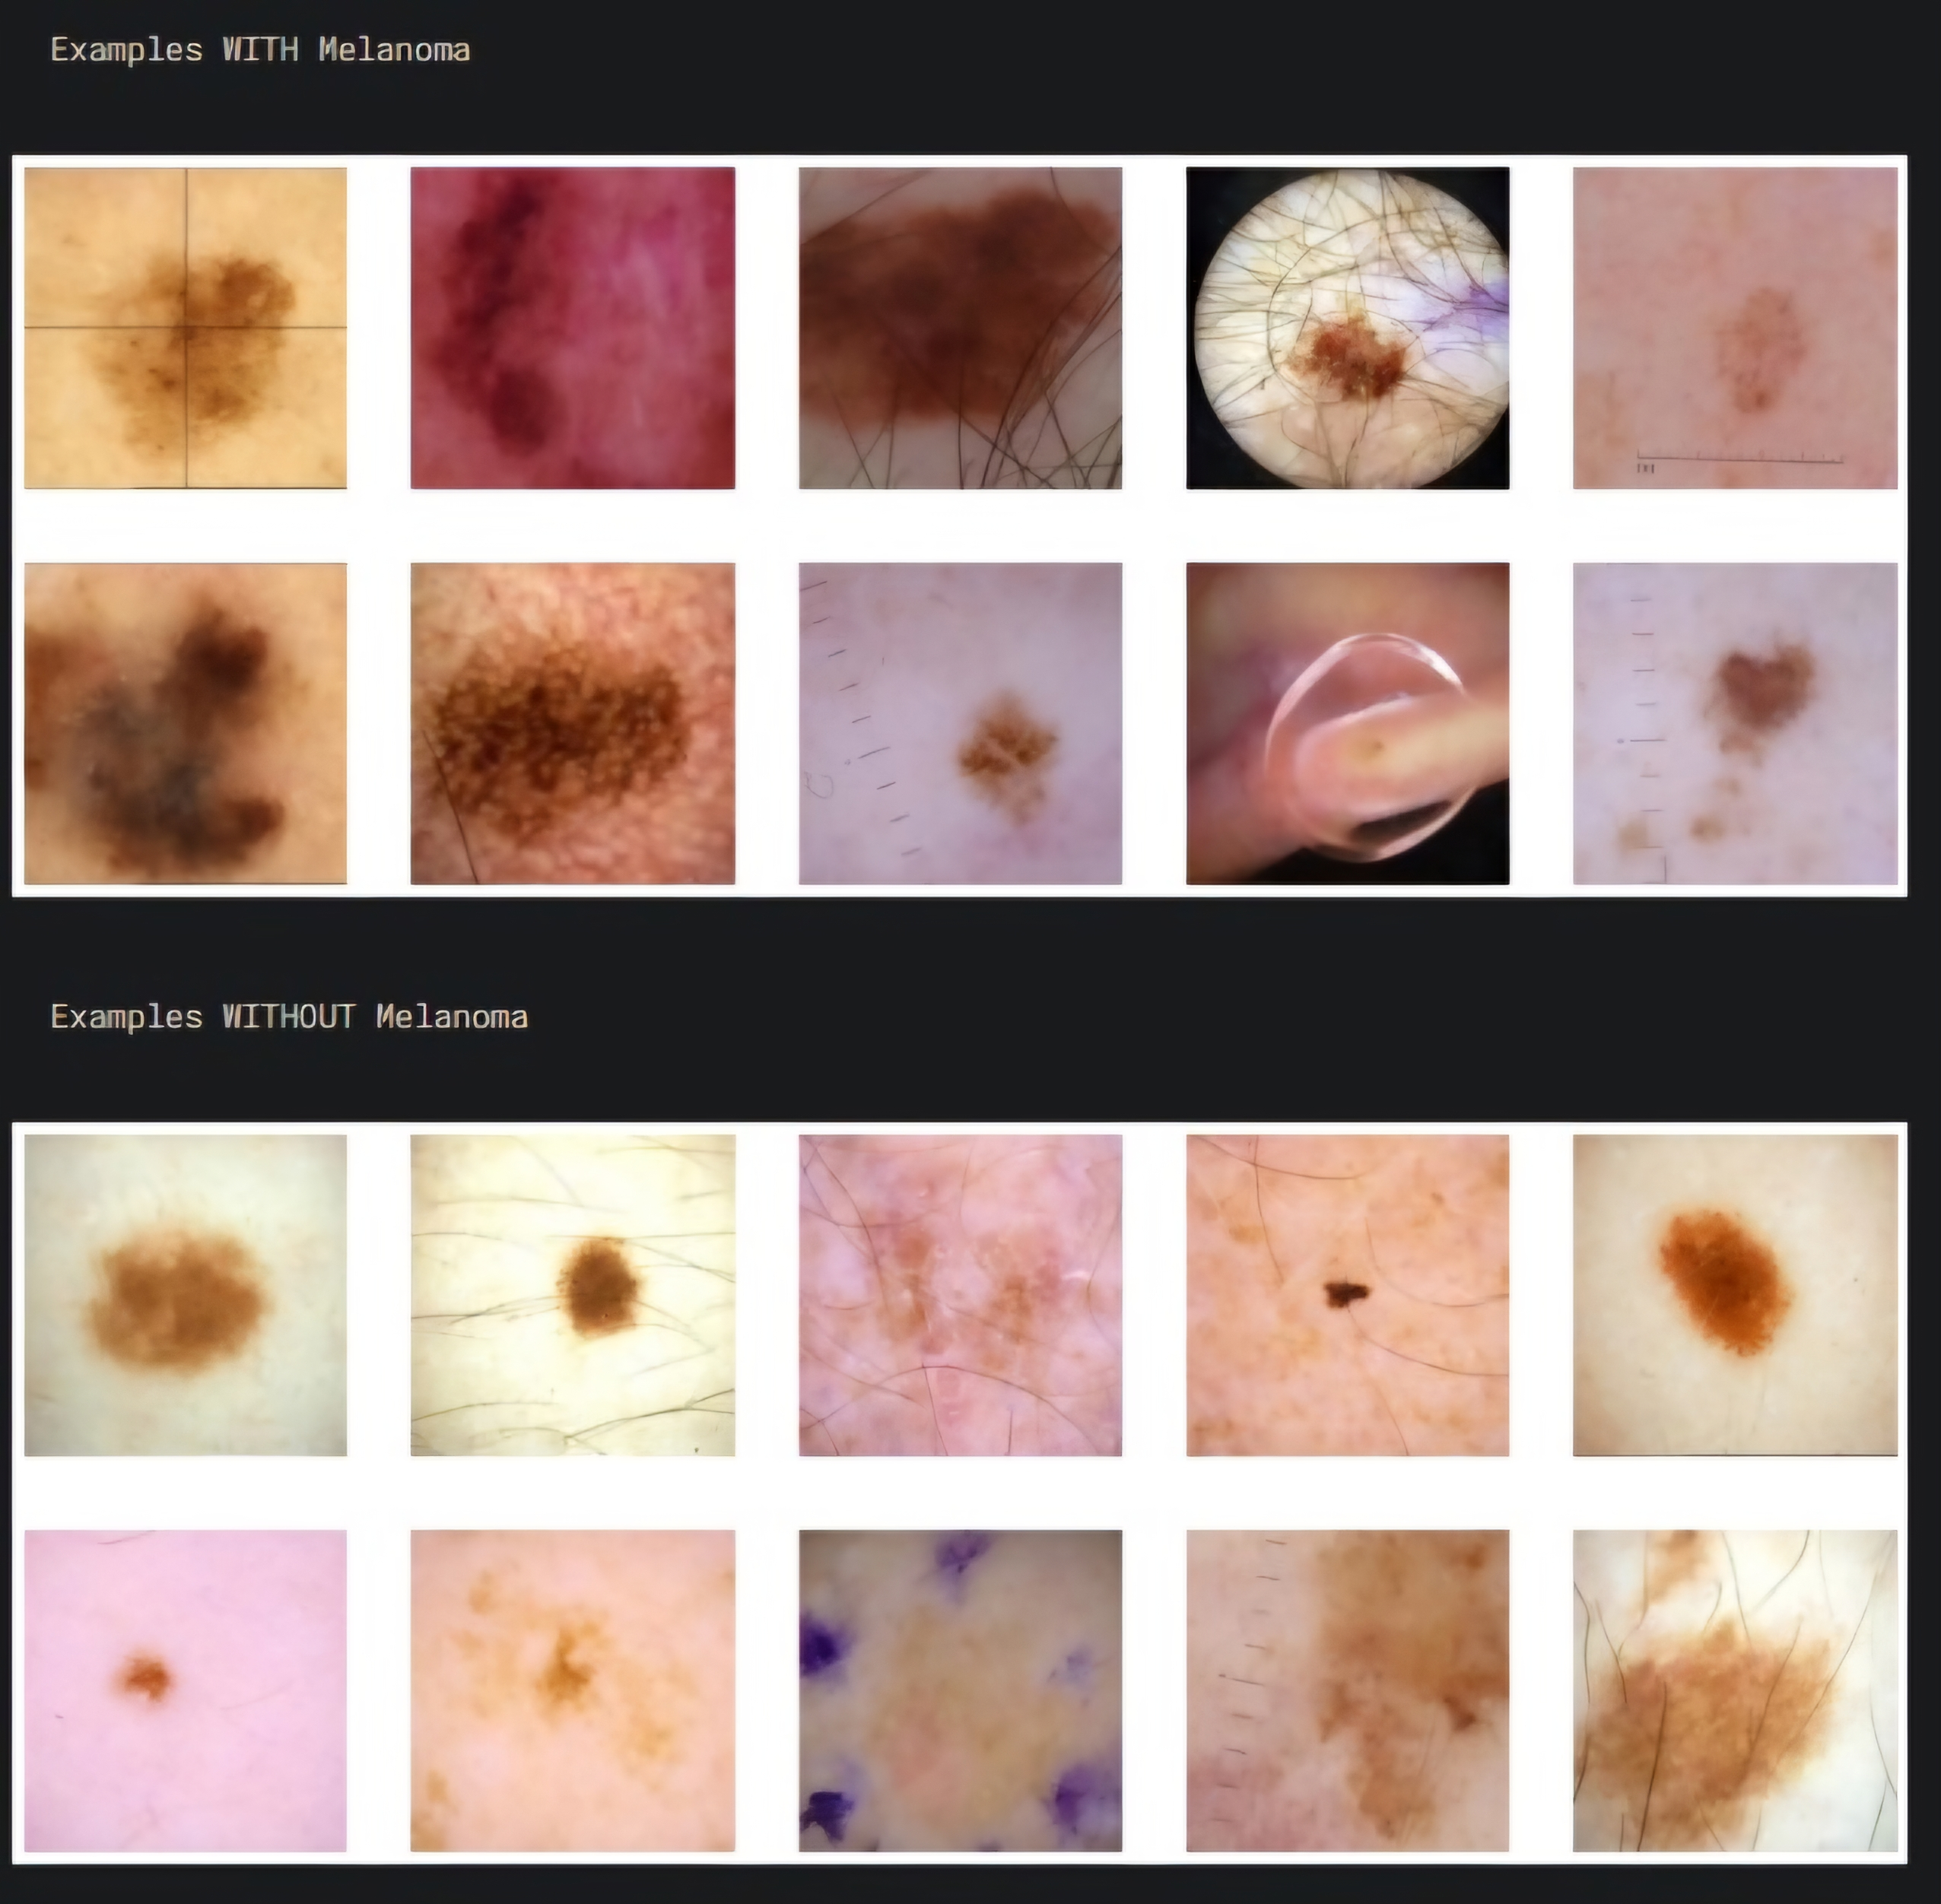

# Requirements

In [ ]:
!pip install kaggle

In [ ]:
# Import necessary libraries
import cv2
import shutil
import random
import zipfile
import warnings
import numpy as np
# %load_ext cudf.pandas
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from google.colab import files
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.callbacks import CSVLogger

# Suppress warnings
warnings.filterwarnings("ignore")

import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Upload
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mohammadhossein77","key":"4b45066c4c15347998fff7a6f7564d95"}'}

In [ ]:
# setup Kaggle dataset
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d amirmohammadparvizi/skin-canser-b584m584

Dataset URL: https://www.kaggle.com/datasets/amirmohammadparvizi/skin-canser-b584m584
License(s): MIT
100% 298M/299M [00:05<00:00, 18.7MB/s]
100% 299M/299M [00:05<00:00, 53.2MB/s]


In [ ]:
# Extract the dataset
zip_ref = zipfile.ZipFile('/content/skin-canser-b584m584.zip', 'r')
zip_ref.extractall('/content/SkinCancerDataset')
zip_ref.close()

In [ ]:
benigns = len(os.listdir("/content/SkinCancerDataset/Melanoma-b584m584/benign"))
melignant = len(os.listdir("/content/SkinCancerDataset/Melanoma-b584m584/malignant"))
print(f"Number of benign Samples: {benigns}\nNumber of malignant Samples: {melignant}")

Number of benign Samples: 584
Number of malignant Samples: 584




> Removing random samples from the majority class



In [ ]:
# Balance the dataset by removing excess samples from the majority class
from random import sample
min_path = "/content/SkinCancerDataset/Melanoma-b584m584/malignant"
maj_path = "/content/SkinCancerDataset/Melanoma-b584m584/benign"
address = [image for image in os.listdir(maj_path)]
cut = len(os.listdir(min_path))
cut_list = sample(address, cut)
for index in tqdm(os.listdir(maj_path)):
    if index not in cut_list:
        os.remove(os.path.join(maj_path, index))

# Verify the number of samples
benigns = len(os.listdir("/content/SkinCancerDataset/Melanoma-b584m584/benign"))
melignant = len(os.listdir("/content/SkinCancerDataset/Melanoma-b584m584/malignant"))
print(f"\nNumber of benign Samples: {benigns}\nNumber of malignant Samples: {melignant}")

100%|██████████| 584/584 [00:00<00:00, 134350.24it/s]


Number of benign Samples: 584
Number of malignant Samples: 584


In [ ]:
# Function to divide test set
def divide_test_set(temp_path, cut_percentage):
    rel_image_paths = [os.path.join(temp_path, i) for i in os.listdir(temp_path)]
    cut_set = random.sample(rel_image_paths, int(cut_percentage * len(os.listdir(temp_path))))
    return cut_set



> Remmeber to Rename "Melanoma-b584m584" folder to "train" before running the next cells


In [ ]:
# Divide the dataset into training and test sets
input_path = "/content/SkinCancerDataset/train/benign"
benign_test_set = divide_test_set(input_path, 0.20)
input_path = "/content/SkinCancerDataset/train/malignant"
malignant_test_set = divide_test_set(input_path, 0.20)

In [ ]:
benign_test_path = "/content/SkinCancerDataset/test/benign"
os.makedirs(benign_test_path, exist_ok=True)
for index in tqdm(benign_test_set):
    shutil.move(index, benign_test_path)

print(len(benign_test_path))

100%|██████████| 116/116 [00:00<00:00, 17468.11it/s]

38


In [ ]:
malignant_test_path = "/content/SkinCancerDataset/test/malignant"
os.makedirs(malignant_test_path, exist_ok=True)
for index in tqdm(malignant_test_set):
    shutil.move(index, malignant_test_path)

print(len(malignant_test_path))

100%|██████████| 116/116 [00:00<00:00, 21247.18it/s]

41




> A bit of EDA out of curiosity (Dont run them)



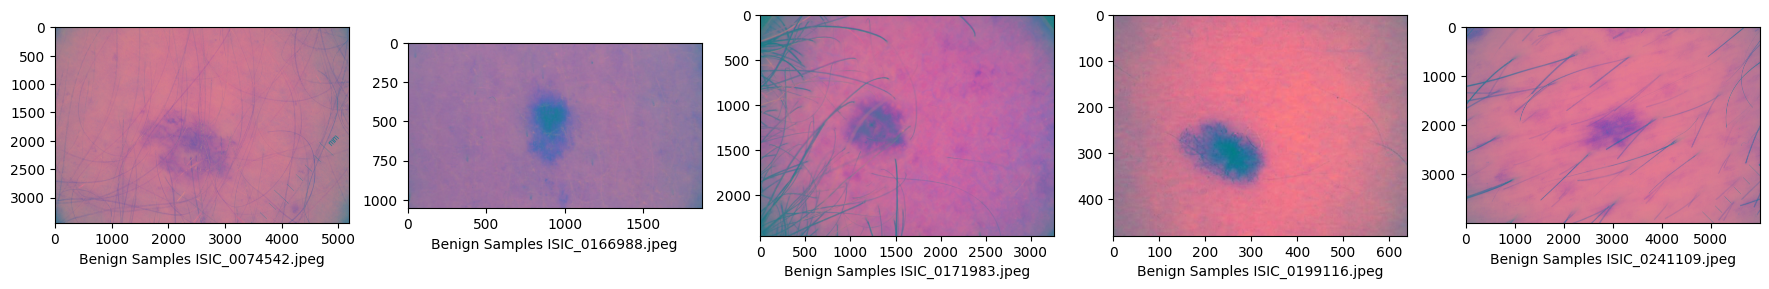

In [ ]:
#  root = "/content/SkinCancerDataset/data/train/benign"

#  fig, ax = plt.subplots(1,5, figsize=(22,8))
#  for i , index in enumerate(os.listdir(root)):
#    if i<5:
#      temp_path = os.path.join(root, index)
#      img = Image.open(temp_path)
#      ax[i].imshow(img)
#      ax[i].set_xlabel(f"Benign Samples {index}", fontsize=10, color='black')

#    else:
#      break

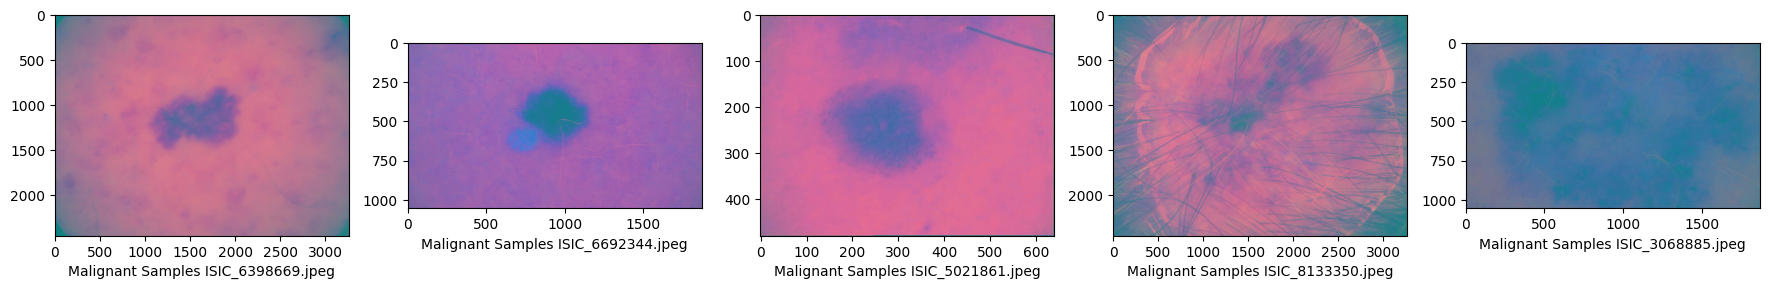

In [ ]:
#  root = "/content/SkinCancerDataset/data/train/malignant"

#  fig, ax = plt.subplots(1,5, figsize=(22,8))
#  for i , index in enumerate(os.listdir(root)):
#    if i<5:
#      temp_path = os.path.join(root, index)
#      img = Image.open(temp_path)
#      ax[i].imshow(img)
#      ax[i].set_xlabel(f"Malignant Samples {index}", fontsize=10, color='black')

#    else:
#      break

In [ ]:
# !zip -r /content/SkinCancerDataset.zip /content/SkinCancerDataset

  adding: content/SkinCancerDataset/ (stored 0%)
  adding: content/SkinCancerDataset/.ipynb_checkpoints/ (stored 0%)
  adding: content/SkinCancerDataset/data/ (stored 0%)
  adding: content/SkinCancerDataset/data/test/ (stored 0%)
  adding: content/SkinCancerDataset/data/test/malignant/ (stored 0%)
  adding: content/SkinCancerDataset/data/test/malignant/ISIC_2535541.jpeg (deflated 6%)
  adding: content/SkinCancerDataset/data/test/malignant/ISIC_2697083.jpeg (deflated 15%)
  adding: content/SkinCancerDataset/data/test/malignant/ISIC_3440759.jpeg (deflated 5%)
  adding: content/SkinCancerDataset/data/test/malignant/ISIC_6931277.jpeg (deflated 10%)
  adding: content/SkinCancerDataset/data/test/malignant/ISIC_3684488.jpeg (deflated 2%)
  adding: content/SkinCancerDataset/data/test/malignant/ISIC_2481044.jpeg (deflated 9%)
  adding: content/SkinCancerDataset/data/test/malignant/ISIC_9583969.jpeg (deflated 7%)
  adding: content/SkinCancerDataset/data/test/malignant/ISIC_3372750.jpeg (deflated

In [ ]:
# lets move it to the Drive ...
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# shutil.copy("/content/SkinCancerDataset.zip", "/content/drive/MyDrive")

'/content/drive/MyDrive/SkinCancerDataset.zip'



> Load and shuffle the data



In [ ]:
# Data generators for training and validation
def create_train_generator(TRAINING_DIR):
    train_datagen = ImageDataGenerator(rescale=1/255)
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=batch_size,
                                                        class_mode='binary',
                                                        target_size=(224, 224))
    return train_generator

def create_val_generator(VAL_DIR):
    val_datagen = ImageDataGenerator(rescale=1/255)
    val_generator = val_datagen.flow_from_directory(directory=VAL_DIR,
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    target_size=(224, 224))
    return val_generator

def create_test_generator(TEST_DIR):
    test_datagen = ImageDataGenerator(rescale=1/255)
    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                      batch_size=batch_size,
                                                      class_mode='binary',
                                                      target_size=(224, 224),
                                                      shuffle=False)
    return test_generator

In [ ]:
# Function to shuffle and split data
def shuffle_and_split_data(src_dir, dest_dir, split_percent):
    image_filenames = os.listdir(src_dir)
    num_images = len(image_filenames)
    random.shuffle(image_filenames)
    num_images_to_move = int(num_images * split_percent)
    for i in tqdm(range(num_images_to_move)):
        src_path = os.path.join(src_dir, image_filenames[i])
        dest_path = os.path.join(dest_dir, image_filenames[i])
        shutil.move(src_path, dest_path)

In [ ]:
# Create train and validation directories
train_benign_dir = "/content/SkinCancerDataset/train/benign"
train_malignant_dir = "/content/SkinCancerDataset/train/malignant"
validation_dir = "/content/SkinCancerDataset/validation"
os.makedirs(validation_dir, exist_ok=True)
validation_benign_dir = os.path.join(validation_dir, "benign")
validation_malignant_dir = os.path.join(validation_dir, "malignant")
os.makedirs(validation_benign_dir, exist_ok=True)
os.makedirs(validation_malignant_dir, exist_ok=True)

In [ ]:
split_percent = 0.20
shuffle_and_split_data(train_benign_dir, validation_benign_dir, split_percent)
shuffle_and_split_data(train_malignant_dir, validation_malignant_dir, split_percent)

print("\nData shuffling and splitting completed.")

100%|██████████| 93/93 [00:00<00:00, 24494.21it/s]


Data shuffling and splitting completed.


In [ ]:
# Verification
va = len(os.listdir("/content/SkinCancerDataset/validation/benign"))
tr = len(os.listdir("/content/SkinCancerDataset/train/benign"))
print(f"\nNumber of benign train Samples: {tr}\nNumber of benign validation Samples: {va}")


Number of benign train Samples: 375
Number of benign validation Samples: 93


In [ ]:
# Verification
va_ = len(os.listdir("/content/SkinCancerDataset/validation/malignant"))
tr_ = len(os.listdir("/content/SkinCancerDataset/train/malignant"))
print(f"\nNumber of malignant train Samples: {tr_}\nNumber of malignant validation Samples: {va_}")


Number of malignant train Samples: 375
Number of malignant validation Samples: 93


In [ ]:
# (it should be ~934)
va+va_+tr_+tr

936

In [ ]:
# Training parameters
batch_size = 4
EPOCHS = 40

In [ ]:
Train_Dir = '/content/SkinCancerDataset/train'
train_generator = create_train_generator(TRAINING_DIR=Train_Dir)

Found 750 images belonging to 2 classes.


In [ ]:
Val_Dir = '/content/SkinCancerDataset/validation'
validation_generator = create_val_generator(VAL_DIR=Val_Dir)

Found 186 images belonging to 2 classes.




> For Future ...



In [ ]:
train_generator.class_indices

{'benign': 0, 'malignant': 1}

# Pilot Modeling

In [ ]:
# Function to build the model
def build_model():
    image_size = 224
    ResNet50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
    model = ResNet50_base.output
    model = tf.keras.layers.GlobalAveragePooling2D()(model)
    model = tf.keras.layers.Dropout(rate=0.35)(model)
    model = tf.keras.layers.Dense(1, activation='sigmoid')(model)
    model = tf.keras.models.Model(inputs=ResNet50_base.input, outputs=model)
    return model

In [ ]:
# For the Debugging Approach

# image_size = 224
# ResNet50 = ResNet50(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

# model = ResNet50.output
# model = tf.keras.layers.Flatten()(model)
# model = tf.keras.layers.Dense(512, activation='relu')(model)
# model = tf.keras.layers.Dropout(0.25)(model)
# model = tf.keras.layers.Dense(256, activation='relu')(model)
# model = tf.keras.layers.Dropout(0.25)(model)
# model = tf.keras.layers.Dense(1, activation='sigmoid')(model)
# model = tf.keras.models.Model(inputs=ResNet50.input, outputs = model)

In [ ]:
# f1 = 2*(tf.compat.v1.metrics.recall(labels, predictions) * tf.compat.v1.metrics.precision(labels, predictions)) / ( tf.compat.v1.metrics.recall(labels, predictions) + tf.compat.v1.metrics.precision(labels, predictions))
# def f1_score(labels, predictions):
  # recall_score = tf.compat.v1.metrics.recall(labels, predictions)
  # precision_score = tf.compat.v1.metrics.precision(labels, predictions)
  # fscore = 2*(recall_score * precision_score) / (recall_score + precision_score)
  # return fscore


In [ ]:
#opt = Adam(learning_rate=0.001)
#model.compile(loss='binary_crossentropy', optimizer = opt, metrics= ['accuracy','Recall','Precision'])

In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=4, min_delta=0.0001, mode='auto', verbose=1)

In [ ]:
# Lists to store specificity and sensitivity
specificities = []
sensitivities = []

In [ ]:
# Ensure TensorFlow uses the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Train the model 6 times
for i in range(6):
    model = build_model()
    opt = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', 'Recall', 'Precision'])

    Train_Dir = '/content/SkinCancerDataset/train'
    train_gen = create_train_generator(TRAINING_DIR=Train_Dir)
    Val_Dir = '/content/SkinCancerDataset/validation'
    val_gen = create_val_generator(VAL_DIR=Val_Dir)

    csv_logger = CSVLogger(f'/content/model_version_{i+1}_log.csv', append=True, separator=',')

    history = model.fit(
        train_gen,
        steps_per_epoch= (tr+tr_)//batch_size,
        epochs=EPOCHS,
        verbose=1,
        validation_data=val_gen,
        callbacks=[reduce_lr, csv_logger]
    )

    test_path = "/content/SkinCancerDataset/test"
    test_gen = create_test_generator(TEST_DIR=test_path)

    predictions = model.predict(test_gen, verbose=1)
    labels = test_gen.classes

    new_list = [0 if value <= 0.50 else 1 for value in predictions]
    cm = confusion_matrix(labels, new_list)

    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    specificities.append(specificity)
    sensitivities.append(sensitivity)

    model.save_weights(f'/content/model_version_{i+1}.h5')

    del model
    del history
    tf.keras.backend.clear_session()

print("Specificities: ", specificities)
print("Sensitivities: ", sensitivities)

94765736/94765736 [==============================] - 0s 0us/step
Found 750 images belonging to 2 classes.
Found 186 images belonging to 2 classes.
Epoch 1/60
93/93 [==============================] - 92s 572ms/step - loss: 0.9024 - accuracy: 0.6469 - recall: 0.6676 - precision: 0.6434 - val_loss: 371.7058 - val_accuracy: 0.5000 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 2/60
93/93 [==============================] - 48s 522ms/step - loss: 0.7195 - accuracy: 0.6590 - recall: 0.7730 - precision: 0.6286 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000 - lr: 0.0010
Epoch 3/60
93/93 [==============================] - 49s 524ms/step - loss: 0.7067 - accuracy: 0.6671 - recall: 0.7480 - precision: 0.6458 - val_loss: 0.6932 - val_accuracy: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000 - lr: 0.0010
Epoch 4/60
93/93 [==============================] - 48s 513ms/step - loss: 0.6411 - accuracy: 0.6846 - recall: 0.7919 - precision

KeyboardInterrupt: 

In [ ]:
# Box plot for specificity and sensitivity
plt.figure(figsize=(10, 5))
plt.boxplot([specificities, sensitivities], labels=['Specificity', 'Sensitivity'])
plt.title('Specificity and Sensitivity across 6 Runs')
plt.ylabel('Scores')
plt.show()

# Plot ROC Curve
fpr, tpr, _ = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot ROC Curve using Specificity and Sensitivity
plt.figure()
plt.plot(1 - np.array(specificities), sensitivities, marker='o', linestyle='-', color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('Receiver Operating Characteristic using Specificity and Sensitivity')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# plot model performance
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['precision']
val_loss = history.history['val_precision']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(11,4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('recall')
plt.title('Model recall')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Model Precision')

plt.tight_layout()
plt.show()

> ### How many of actual positives where detected?

Sensitivity (Recall) = TP/TP+FN

---

> ### How many of total positive predictions are actually positive?

Precision = TP/TP+FP

---

> ### How many of total negative predictions are actually negative?

Specifcity = TN/TN+FP (How many of actual positives where detected)




In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(11,4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Accuracy and loss plots
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("/content/resNet50_V3.h5")

Move the weights to Drive for possible future Debug

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
shutil.copy("/content/resNet50_V3.h5", "/content/drive/MyDrive")

# Testing

In [ ]:
def test_generator(path):

    train_datagen = ImageDataGenerator(rescale=1/255)
    train_generator = train_datagen.flow_from_directory(directory=path,
                                                        batch_size=1,
                                                        class_mode='binary',
                                                        target_size=(224, 224))

    return train_generator

In [ ]:
test_path = "/content/SkinCancerDataset/data/test"
test_generator = test_generator(test_path)

In [ ]:
model.evaluate(test_generator)



> ### Test Report

Precision = 0.76

Recall = 0.71

Accuracy = 0.74



#### These lines are just for experimenting ...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model = load_model("/content/drive/MyDrive/resNet50_V3.h5")

In [ ]:
from PIL import Image

root = "/content/SkinCancerDataset/data/test"
predictions = []
labels = []

for label in tqdm(os.listdir(root)):
  if label == "malignant":
    new_root = os.path.join(root, label)
    for image in tqdm(os.listdir(new_root)):
      # read, covert, and normalize the image
      img_path = os.path.join(new_root, image)
      image_file = Image.open(img_path).convert('RGB')
      image_array = np.array(image_file)
      # image_array = image_array * 255.0/image_array.max()
      image_array = cv2.resize(image_array, (224,224))
      image_array = image_array / 255.0
      image_array = image_array.reshape(1, 224,224, 3)
      # Prediction
      predictions.append(model.predict(image_array, verbose=0).squeeze())
      labels.append(1)


  elif label == "benign":
    new_root = os.path.join(root, label)
    for image in tqdm(os.listdir(new_root)):
      # read, covert, and normalize the image
      img_path = os.path.join(new_root, image)
      image_file = Image.open(img_path).convert('RGB')
      image_array = np.array(image_file)
      # image_array = image_array * 255.0/image_array.max()
      image_array = cv2.resize(image_array, (224,224))
      image_array = image_array / 255.0
      image_array = image_array.reshape(1, 224,224, 3)
      # Prediction
      predictions.append(model.predict(image_array, verbose=0).squeeze())
      labels.append(0)

  else:
    print("\nSomething is not right!")




In [ ]:
new_list = [0 if value <= 0.50 else 1 for value in predictions]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

confusion_matrix(labels, new_list)

In [ ]:
sns.heatmap(confusion_matrix(labels, new_list), annot=True, cmap="Blues")



# TODO

*   SMOTE
*   Data Augmentation
*   More Complex Models



